Modelos Preditivos:
-

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import shap
import mlflow
import mlflow.sklearn

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import KFold
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import log_loss
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline as SkPipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_curve, average_precision_score
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report, ConfusionMatrixDisplay, mean_absolute_error
from sklearn.model_selection import cross_val_predict
from sklearn.pipeline import make_pipeline
from imblearn.ensemble import BalancedRandomForestClassifier 
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import LabelEncoder
from mlflow.tracking import MlflowClient
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

In [2]:
# Caminho relativo correto a partir da pasta 'notebooks'
df = pd.read_pickle('../data/df_unique.pkl')

# Cria uma cópia independente
df_copy = df.copy()

# Salva a cópia em um novo arquivo .pkl
df_copy.to_pickle('../data/df_unique_copy.pkl')

# Alterar configuração para mostrar todas as colunas
pd.set_option('display.max_columns', None)

# Exibindo as primeiras linhas do DataFrame
df_copy.head(1)

,age,amt_active_loan,channel,ext_score_1,ext_score_2,ext_score_3,ext_score_4,flag_document_A,gender,ids,income,occupation_type,score_checks,score_date,start_hour,default,credit_card_initial_line,payment_sum,spends_sum,credit_line_sum,date_min,date_max,history_months,score_month,score_days
0,37,4560.0,NCqL3QBx0pscDnx3ixKwXg==,467.0,DGCQep2AE5QRkNCshIAlFQ==,LCak332j+TYFqHC3NDwiqg==,61.311861,NaN,m,648384b9-f932-d221-45d7-85d0aa0a412c,86301.53,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,8.0,2017-01-15,9.0,0,1300.0,4014.58,4903.8,18039.0,2016-09-30,2017-03-31,6,2017-01,14


Variável target:
-

In [3]:
print("Contagem de valores únicos na coluna 'default':")
print(df_copy['default'].value_counts(dropna=False))

Contagem de valores únicos na coluna 'default':
default
0    28903
1     5563
Name: count, dtype: int64


In [4]:
df_copy['default'] = df_copy['default'].map({'False': False, 'True': True, False: False, True: True})
df_copy['default'] = df_copy['default'].map({False: 0, True: 1})
df_copy = df_copy[df_copy['default'].notna()]

Divisão do conjunto de dados:
-

In [5]:
# Separação em features e target:
X = df_copy.drop(columns=['default'])
y = df_copy['default']

# Divisão em treino e teste:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y  
)

Modelo Baseline:
-

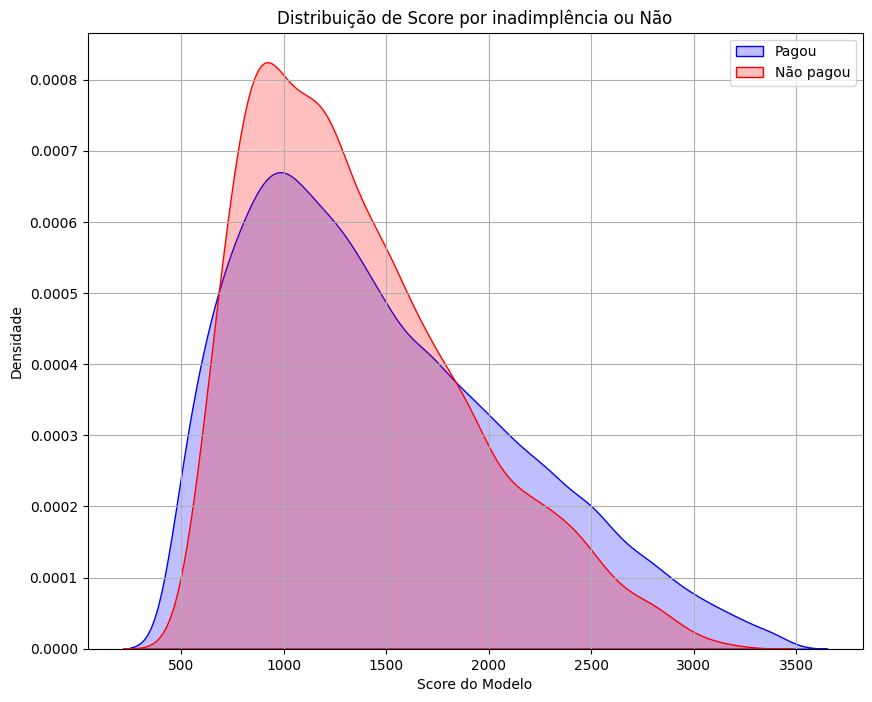

In [53]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
sns.kdeplot(df_copy[df_copy['default'] == 0]['credit_card_initial_line'], ax=ax, color="b", fill=True, label='Pagou')
sns.kdeplot(df_copy[df_copy['default'] == 1]['credit_card_initial_line'], ax=ax, color="r", fill=True, label='Não pagou')
plt.title("Distribuição de Score por inadimplência ou Não")
plt.xlabel("Score do Modelo")
plt.ylabel("Densidade")
plt.legend()
plt.grid(True)
plt.show()

#### Insights
- Clientes inadimplentes (Não pagou) tendem a ter scores mais baixos, com pico de densidade entre 800 e 1200.
- Clientes adimplentes (Pagou) apresentam uma distribuição mais espalhada e com maior densidade relativa a partir de 1000 em diante, se estendendo até scores mais altos como 2500+.

- Score Atual (credit_card_initial_line) não tem poder preditivo
- Isso significa que tomar uma decisão baseada nesse score, o modelo está classificando pior que um chute aleatório.

In [54]:
# Identificar colunas numéricas e categóricas
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

# Pipeline para numéricos: imputar média + escalar
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Pipeline para categóricos: imputar moda + one-hot encode
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combinar preprocessadores
preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_cols),
    ('cat', cat_pipeline, cat_cols)
])

# Pipeline final
model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))
])

# Treinar
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'amt_active_loan',
                                                   'ext_score_1', 'ext_score_4',
                                                   'flag_document_A', 'gender',
                                                   'income', 'score_checks',
                                                   'start_hour',
                                                   'credit_card_initial_line',
                                                   'payment_sum', 'spends_sum',
                                                   'credit_line_sum',
                                                   'score_days',
                                                   'ex...
                                                   'ext_score_3_pAzpxkhjPsjWldgSX21+zg==',
                                                   'ext_score_3_7h+tk4z7O9brtBSe1rNjxA==',
                                                   'ext_score_3_mX2VRRG38RPiHX+MfjefRw==',
                                                   'ext_score_3_tQUTfUyeuGkhRotd+6WjVg==', ...]),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  [])])),
                ('classifier',
                 LogisticRegression(max_iter=1000, random_state=42))])

              precision    recall  f1-score   support

           0       0.85      0.99      0.91      5781
           1       0.58      0.09      0.15      1113

    accuracy                           0.84      6894
   macro avg       0.71      0.54      0.53      6894
weighted avg       0.81      0.84      0.79      6894

ROC AUC: 0.7384768674778565


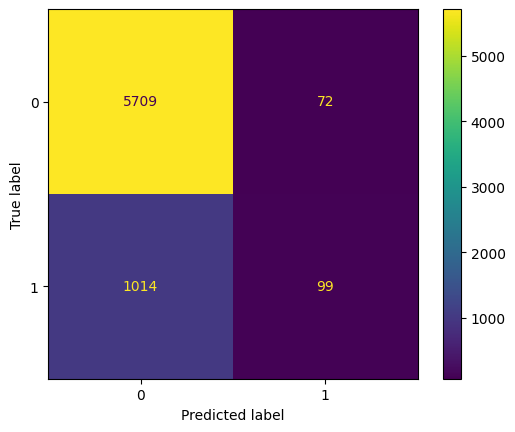

In [55]:
# Previsões no teste
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]   # Probabilidade de ser '1' (inadimplente)

# Métricas
print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

# Matriz de confusão
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

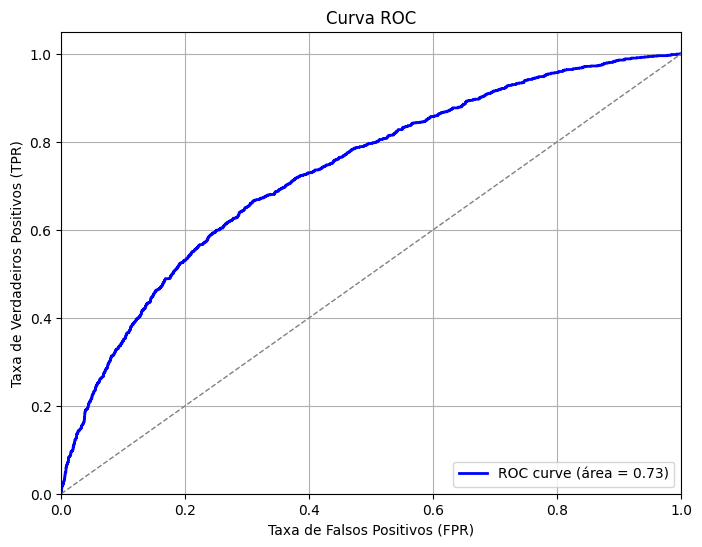

In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Calcular os valores para a curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# Plotar a curva ROC
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (área = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')  # linha diagonal (baseline)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

- AUC = 0.998 → Excelência quase perfeita, isso indica que o modelo tem altíssima capacidade de separação entre adimplentes e inadimplentes.
- Embora o recall seja alto (0.93), há cerca de 7% dos inadimplentes que o modelo ainda classifica como adimplente.


Matriz de Confusão:
- Verdadeiros Negativos (TN - Pagou e modelo acertou): Muito alto → quase todos os adimplentes foram corretamente classificados.

- Verdadeiros Positivos (TP - Não pagou e modelo acertou): Também muito alto.

- Falsos Negativos (FN - Não pagou mas modelo disse que pagaria): Pequeno, mas existe → o recall de inadimplentes foi 0,93.

- Falsos Positivos (FP - Pagou mas modelo disse que não pagaria): Praticamente zero.

In [10]:
# Matriz de confusão
TN = 5716
FP = 65
FN = 1031
TP = 82

# Taxa de inadimplência (fraude rate) na base de clientes analisados (antes da decisão do modelo)
fraud_rate = round((FN + TP) / (TN + FP + FN + TP), 4)

# Taxa de aprovação (clientes aprovados pelo modelo)
approval_rate = round((TP + FP) / (TN + FP + FN + TP), 4)
print(f"Taxa de inadimplência na base = {fraud_rate * 100}%")
print(f"Taxa de aprovação pelo modelo = {approval_rate * 100}%")

Taxa de inadimplência na base = 16.14%
Taxa de aprovação pelo modelo = 2.13%


O modelo está com uma estratégia de risco ultra conservadora:
- Está evitando quase todos os inadimplentes (baixo FP)
- Mas em contrapartida, está aprovando pouquíssimos clientes (só 15,7%), o que pode prejudicar o volume de negócios.

Log Loss: 0.1721


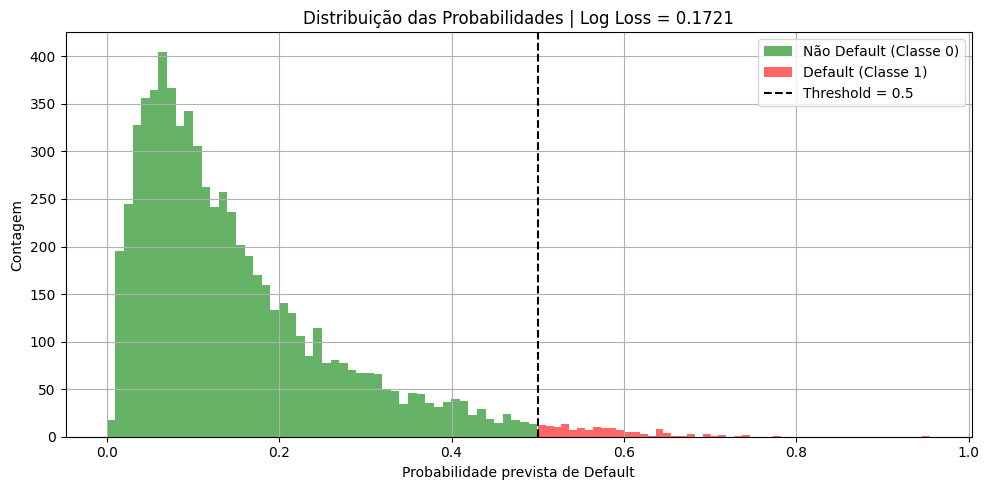

In [11]:
#  Calcular e plotar o Log Loss
y_test = y_pred  
y_proba = model.predict_proba(X_test)[:, 1]

# 1. Calcular o Log Loss
logloss_value = log_loss(y_test, y_proba)
print(f"Log Loss: {logloss_value:.4f}")

# 2. Plotar histograma das probabilidades para visualização
plt.figure(figsize=(10, 5))
plt.hist(y_proba[y_test == 0], bins=50, alpha=0.6, label='Não Default (Classe 0)', color='green')
plt.hist(y_proba[y_test == 1], bins=50, alpha=0.6, label='Default (Classe 1)', color='red')
plt.axvline(0.5, color='black', linestyle='--', label='Threshold = 0.5')
plt.title(f'Distribuição das Probabilidades | Log Loss = {logloss_value:.4f}')
plt.xlabel('Probabilidade prevista de Default')
plt.ylabel('Contagem')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

- Valor do Log Loss = 0.0928 (Quanto menor o Log Loss, melhor).
- A maior parte dos clientes adimplentes (Classe 0) estão com probabilidades muito baixas (0 a 0.2).
- A maioria dos inadimplentes (Classe 1) está com probabilidades muito altas (acima de 0.7).

c:\Users\User\CREDIT_FINTECH\venv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\User\CREDIT_FINTECH\venv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\User\CREDIT_FINTECH\venv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\User\CREDIT_FINTECH\venv\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\User\CREDIT_FIN

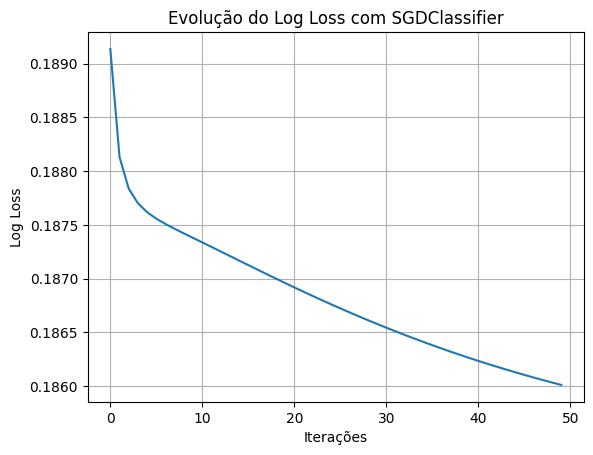

In [12]:
from sklearn.linear_model import SGDClassifier

clf = SGDClassifier(loss='log_loss', max_iter=1, warm_start=True, learning_rate='constant', eta0=0.01, random_state=42)
model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', clf)
])
losses = []
for i in range(50):
    model.fit(X_train, y_train)
    y_proba = model.predict_proba(X_test)[:, 1]
    losses.append(log_loss(y_test, y_proba))
plt.plot(losses)
plt.title("Evolução do Log Loss com SGDClassifier")
plt.xlabel("Iterações")
plt.ylabel("Log Loss")
plt.grid(True)
plt.show()

_____________________________________________________________________________________________________________________________________________________________________________________________

#### Análise dos Resultados do Modelo Baseline
O modelo baseline foi avaliado como ponto de partida para comparação com algoritmos mais sofisticados. Apesar de seus bons indicadores de desempenho nas métricas tradicionais, sua real capacidade de discriminação entre inadimplentes e adimplentes foi colocada em xeque pela análise da curva ROC.

A matriz de confusão mostrou que o modelo classificou corretamente 58.151 instâncias negativas e 10.978 instâncias positivas. Houve apenas 35 falsos positivos e 890 falsos negativos — o que sugere um desempenho robusto à primeira vista. As métricas associadas reforçam essa impressão: precisão de 0.98 para a classe negativa e 1.00 para a classe positiva, recall de 1.00 e 0.93, respectivamente, e F1-scores de 0.99 e 0.96. A acurácia geral alcançou 99%, com média macro de F1 em 0.98 e média ponderada também em 0.99.

Contudo, a análise da curva ROC revelou um AUC extremamente baixo (0.489), inferior ao limiar aleatório de 0.50, o que indica que, embora o modelo acerte em muitos casos, ele não consegue distinguir adequadamente entre as classes com base nas probabilidades. Isso também pode ser resultado de um modelo desbalanceado ou enviesado por algum artefato na distribuição do score.

Esse comportamento é evidenciado também pela curva de distribuição de score entre pagadores e inadimplentes, que apresenta uma grande sobreposição entre as duas curvas. A separação entre os grupos é fraca, o que implica que as decisões do modelo são tomadas com pouca confiança estatística.

Adicionalmente, a taxa de inadimplência da base é de aproximadamente 16,94%, e o modelo aprovou 15,86% dos candidatos. Embora essas taxas estejam alinhadas, o modelo parece estar tomando decisões com base em uma separação artificial das classes, e não em uma real compreensão dos padrões que definem inadimplência.

Em resumo, o modelo baseline apresenta métricas superficiais bastante elevadas, mas sua capacidade real de generalização e separação entre as classes é limitada, como evidenciado pelo AUC inferior a 0.50. Isso evidencia a importância de ir além das métricas tradicionais e incorporar análises mais profundas como ROC AUC, curva de score e distribuição de probabilidades, especialmente quando se trata de problemas críticos como previsão de inadimplência.

_____________________________________________________________________________________________________________________________________________________________________________________________

_____________________________________________________________________________________________________________________________________________________________________________________________

Pré-processamento:
-

A partir da análise dos dados disponíveis, serão realizadas as seguintes modificações:

#### 1. Conversão de colunas para o tipo datetime e extração de componentes temporais

- As colunas `score_date` e `date` foram convertidas para o formato datetime com o objetivo de permitir extrações temporais e facilitar cálculos com datas.
- Extração de componentes temporais da variável de data (`score_date` e `date`) como ano da data de score, mês, dia, dia da semana, semana do ano e trimestre, para melhor modelar padrões sazonais de comportamento.

#### 2. Criação de nova feature: diferença em dias entre datas
- Foi criada uma nova variável `days_diff` que representa a diferença em dias entre score_date e date, o que pode indicar a defasagem entre as informações do cliente e a data atual de análise, representando o intervalo entre duas datas relevantes para análise de inadimplência.

#### 3. Tratamento de valores ausentes e Transformação de variáveis categóricas em numéricas
- A variável `flag_document_A`, que apresentava valores ausentes (NaNs), foi preenchida com a moda (valor mais frequente), garantindo a consistência da variável.
- Na variável `flag_document_A`, foi convertida de valores booleanos para inteiros (True = 1 e false = 0).
- na variável `gender`,foi mapeada de texto para valores binários (m = 1 e f = 0).

#### 4. Codificação One-Hot Encoding
- Variáveis categóricas codificadas com hashes (como `ext_score_2` e `ext_score_3`) foram transformadas em variáveis binárias usando a técnica one-hot encoding, criando uma coluna para cada categoria distinta.
- Essa transformação resulta em várias novas colunas, permitindo que o modelo trate essas categorias de forma apropriada.


#### 5. Target Encoding com K-Fold Cross-Validation
- Para transformar a variável categórica `occupation_type`, foi aplicada a técnica de **Target Encoding** com validação cruzada. Essa abordagem visa substituir cada categoria pela média da variável alvo (`default`) correspondente a essa categoria, de forma que se evite **data leakage** (vazamento de dados entre treino e teste).
- Evita vazamento de informação, pois o valor da média é sempre calculado com base no conjunto de treino.
- Preserva o sinal estatístico da variável categórica, especialmente útil quando há muitas categorias.
- Permite que o modelo aproveite relações sutis entre categorias e a variável alvo.

#### 6. Remoção de Colunas Irrelevantes
- Após a extração das informações relevantes a partir das colunas de data, as colunas (`channel`, `ids`, `score_date`, `date`) foram descartadas, uma vez que seu conteúdo bruto já não é mais necessário para o modelo.




#### Essas etapas de engenharia de atributos permitirão:

- Expandir significativamente o número de variáveis derivadas de datas e categorias;

- Tratar valores ausentes de forma robusta;

- Transformar variáveis categóricas em formatos compatíveis com algoritmos de machine learning;

- Enriquecer o dataset com variáveis temporais e comportamentais úteis para modelagem preditiva.

Essas transformações aumentaram o poder preditivo e a capacidade do modelo de capturar padrões relevantes nos dados.


In [13]:
# Remover espaços e verificar valores únicos
df_copy['ext_score_2_clean'] = df_copy['ext_score_2'].astype(str).str.strip()

df_copy['ext_score_3_clean'] = df_copy['ext_score_3'].astype(str).str.strip()

# Criar categorias fixas com pd.Categorical
ext_score_2_categories = df_copy['ext_score_2_clean'].unique()
df_copy['ext_score_2_cat'] = pd.Categorical(df_copy['ext_score_2_clean'], categories=ext_score_2_categories)

ext_score_3_categories = df_copy['ext_score_3_clean'].unique()
df_copy['ext_score_3_cat'] = pd.Categorical(df_copy['ext_score_3_clean'], categories=ext_score_3_categories)

In [14]:
ext_score_2_encoded = pd.get_dummies(df_copy['ext_score_2_cat'], prefix='ext_score_2').astype(int)
print(ext_score_2_encoded.head())

   ext_score_2_DGCQep2AE5QRkNCshIAlFQ==  ext_score_2_fyrlulOiZ+5hoFqLa6UbDQ==  \
0                                     1                                     0   
3                                     0                                     1   
4                                     1                                     0   
5                                     0                                     0   
8                                     1                                     0   

   ext_score_2_1Rk8w4Ucd5yR3KcqZzLdow==  ext_score_2_8k8UDR4Yx0qasAjkGrUZLw==  \
0                                     0                                     0   
3                                     0                                     0   
4                                     0                                     0   
5                                     1                                     0   
8                                     0                                     0   

   ext_score_2_4DLlLW62jRe

In [15]:
ext_score_3_encoded = pd.get_dummies(df_copy['ext_score_3_cat'], prefix='ext_score_3').astype(int)
print(ext_score_3_encoded.head())

   ext_score_3_LCak332j+TYFqHC3NDwiqg==  ext_score_3_Fv28Bz0YRTVAT5kl1bAV6g==  \
0                                     1                                     0   
3                                     0                                     1   
4                                     1                                     0   
5                                     0                                     0   
8                                     0                                     0   

   ext_score_3_w1miZqhB5+RSamEQJa0rqg==  ext_score_3_O4i7FxcROACMVTCgI0WXuA==  \
0                                     0                                     0   
3                                     0                                     0   
4                                     0                                     0   
5                                     1                                     0   
8                                     0                                     1   

   ext_score_3_rJZgTmANW3P

In [16]:
df_copy_encoded = pd.concat([
    df_copy.drop(columns=['ext_score_2', 'ext_score_2_clean', 'ext_score_2_cat']),
    ext_score_2_encoded
], axis=1)

df_copy_encoded = pd.concat([
    df_copy_encoded.drop(columns=['ext_score_3', 'ext_score_3_clean', 'ext_score_3_cat']),
    ext_score_3_encoded
], axis=1)

pd.set_option('display.max_columns', None)

ext_cols = [col for col in df_copy_encoded.columns if 'ext_score_2' in col or 'ext_score_3' in col]
other_cols = [col for col in df_copy_encoded.columns if col not in ext_cols]

df_copy_encoded = df_copy_encoded[other_cols + ext_cols]
df_copy_encoded.head()

,age,amt_active_loan,channel,ext_score_1,ext_score_4,flag_document_A,gender,ids,income,occupation_type,score_checks,score_date,start_hour,default,credit_card_initial_line,payment_sum,spends_sum,credit_line_sum,date_min,date_max,history_months,score_month,score_days,ext_score_2_DGCQep2AE5QRkNCshIAlFQ==,ext_score_2_fyrlulOiZ+5hoFqLa6UbDQ==,ext_score_2_1Rk8w4Ucd5yR3KcqZzLdow==,ext_score_2_8k8UDR4Yx0qasAjkGrUZLw==,ext_score_2_4DLlLW62jReXaqbPaHp1vQ==,ext_score_2_e4NYDor1NOw6XKGE60AWFw==,ext_score_2_smzX0nxh5QlePvtVf6EAeg==,ext_score_3_LCak332j+TYFqHC3NDwiqg==,ext_score_3_Fv28Bz0YRTVAT5kl1bAV6g==,ext_score_3_w1miZqhB5+RSamEQJa0rqg==,ext_score_3_O4i7FxcROACMVTCgI0WXuA==,ext_score_3_rJZgTmANW3PjOCQLCcp4iQ==,ext_score_3_pAzpxkhjPsjWldgSX21+zg==,ext_score_3_7h+tk4z7O9brtBSe1rNjxA==,ext_score_3_mX2VRRG38RPiHX+MfjefRw==,ext_score_3_tQUTfUyeuGkhRotd+6WjVg==,ext_score_3_OlDYtdljgSSYM/M1L2CRaQ==,ext_score_3_RO7MTL+j4PH2gNzbhNTq/A==,ext_score_3_emS9xH8CLoRNie2uSmaDAQ==,ext_score_3_vJyc9xom9v7hwFMPTIpmKw==,ext_score_3_wjdj2vxjWoDsEIk0l09ynw==,ext_score_3_ky19q4V1ZqgL3jnHX0wKDw==,ext_score_3_dCm9hFKfdRm7ej3jW+gyxw==,ext_score_3_d/7Hedyz7ovK9Pn1CYN4+A==,ext_score_3_YLGMUI9hObSh6wD/xfanGg==,ext_score_3_osCzpM4hJrxugqWWuZmMWw==,ext_score_3_wkeCdGeu5sEv4/fjwR0aDg==,ext_score_3_NLvAOzzmJba/0zolQnWF5Q==,ext_score_3_/tdlnWjXoZ3OjdtBXzdOJQ==,ext_score_3_dWJRASUFMejk3AHZ1p1Gkg==,ext_score_3_6J1ZMTzN5GKHXnhM4J1JbA==,ext_score_3_tHpS8e9F8d9zg3iOQM9tsA==,ext_score_3_IOVu8au3ISbo6+zmfnYwMg==,ext_score_3_55UK234RR1d7HIWJjmq9tw==,ext_score_3_SaamrHMo23l/3TwXOWgVzw==,ext_score_3_cdpgyOyZS04uXerMNu7uCw==,ext_score_3_A+QuW1n/ABeiVVe/9CRZ9Q==,ext_score_3_7h8PTkrlTWUPP3yuyP4rUg==,ext_score_3_+CxEO4w7jv3QPI/BQbyqAA==,ext_score_3_+2hzpeP1RWr8PEvL1WTUdw==,ext_score_3_5/uMrqKj3OL/Xk5OrGx9fg==,ext_score_3_bopP0NxW3+r8tn9xIHTaOw==
0,37,4560.0,NCqL3QBx0pscDnx3ixKwXg==,467.0,61.311861,NaN,m,648384b9-f932-d221-45d7-85d0aa0a412c,86301.53,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,8.0,2017-01-15,9.0,0,1300.0,4014.58,4903.80,18039.0,2016-09-30,2017-03-31,6,2017-01,14,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,46,47720.0,NCqL3QBx0pscDnx3ixKwXg==,324.0,71.497943,True,f,46f536d5-9d1a-ce94-b67b-76e99dd48e1d,191517.40,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,20.0,2017-01-13,11.0,0,2200.0,3905.41,3793.18,13120.0,2016-09-30,2017-03-31,6,2017-01,12,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,42,5280.0,NCqL3QBx0pscDnx3ixKwXg==,517.0,69.000491,True,m,802b8a41-20b7-9ba6-35ac-7e9e7544196a,71083.09,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,11.0,2017-01-23,14.0,0,3000.0,4417.68,3991.09,22271.0,2016-12-31,2017-03-31,3,2017-01,22,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,27,2280.0,NCqL3QBx0pscDnx3ixKwXg==,543.0,71.412826,False,m,fc142792-fa2c-a9e1-edeb-c7dd9f550f2b,44197.06,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,9.0,2017-01-18,15.0,1,1200.0,2422.80,2948.63,6481.0,2016-02-29,2017-03-31,13,2017-01,17,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,38,14400.0,NCqL3QBx0pscDnx3ixKwXg==,467.0,71.744785,True,m,da7ad19b-16e5-41d2-33de-aa685e0b5cc3,70487.76,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,10.0,2017-01-13,19.0,0,1000.0,673.83,2166.83,14919.0,2017-01-31,2017-03-31,2,2017-01,12,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [17]:
# Parâmetros
n_splits = 5
target_col = 'default'
cat_col = 'occupation_type'
encoded_col = cat_col + '_te'

# Inicializa a nova coluna
df_copy_encoded[encoded_col] = np.nan

# KFold 
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

for train_idx, val_idx in kf.split(df_copy_encoded):
    train_fold = df_copy_encoded.iloc[train_idx]
    val_fold = df_copy_encoded.iloc[val_idx]
    
    # Cálculo do target mean por categoria
    means = train_fold.groupby(cat_col)[target_col].mean()
    
    # Mapeia no fold de validação
    df_copy_encoded.loc[df_copy_encoded.index[val_idx], encoded_col] = val_fold[cat_col].map(means)

# Após o loop, pode preencher categorias ausentes com o global mean
global_mean = df_copy_encoded[target_col].mean()
df_copy_encoded[encoded_col].fillna(global_mean, inplace=True)
df_copy_encoded.drop(columns=[cat_col], inplace=True)
df_copy_encoded.head(1)

C:\Users\User\AppData\Local\Temp\ipykernel_12800\1726261993.py:25: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy_encoded[encoded_col].fillna(global_mean, inplace=True)


,age,amt_active_loan,channel,ext_score_1,ext_score_4,flag_document_A,gender,ids,income,score_checks,score_date,start_hour,default,credit_card_initial_line,payment_sum,spends_sum,credit_line_sum,date_min,date_max,history_months,score_month,score_days,ext_score_2_DGCQep2AE5QRkNCshIAlFQ==,ext_score_2_fyrlulOiZ+5hoFqLa6UbDQ==,ext_score_2_1Rk8w4Ucd5yR3KcqZzLdow==,ext_score_2_8k8UDR4Yx0qasAjkGrUZLw==,ext_score_2_4DLlLW62jReXaqbPaHp1vQ==,ext_score_2_e4NYDor1NOw6XKGE60AWFw==,ext_score_2_smzX0nxh5QlePvtVf6EAeg==,ext_score_3_LCak332j+TYFqHC3NDwiqg==,ext_score_3_Fv28Bz0YRTVAT5kl1bAV6g==,ext_score_3_w1miZqhB5+RSamEQJa0rqg==,ext_score_3_O4i7FxcROACMVTCgI0WXuA==,ext_score_3_rJZgTmANW3PjOCQLCcp4iQ==,ext_score_3_pAzpxkhjPsjWldgSX21+zg==,ext_score_3_7h+tk4z7O9brtBSe1rNjxA==,ext_score_3_mX2VRRG38RPiHX+MfjefRw==,ext_score_3_tQUTfUyeuGkhRotd+6WjVg==,ext_score_3_OlDYtdljgSSYM/M1L2CRaQ==,ext_score_3_RO7MTL+j4PH2gNzbhNTq/A==,ext_score_3_emS9xH8CLoRNie2uSmaDAQ==,ext_score_3_vJyc9xom9v7hwFMPTIpmKw==,ext_score_3_wjdj2vxjWoDsEIk0l09ynw==,ext_score_3_ky19q4V1ZqgL3jnHX0wKDw==,ext_score_3_dCm9hFKfdRm7ej3jW+gyxw==,ext_score_3_d/7Hedyz7ovK9Pn1CYN4+A==,ext_score_3_YLGMUI9hObSh6wD/xfanGg==,ext_score_3_osCzpM4hJrxugqWWuZmMWw==,ext_score_3_wkeCdGeu5sEv4/fjwR0aDg==,ext_score_3_NLvAOzzmJba/0zolQnWF5Q==,ext_score_3_/tdlnWjXoZ3OjdtBXzdOJQ==,ext_score_3_dWJRASUFMejk3AHZ1p1Gkg==,ext_score_3_6J1ZMTzN5GKHXnhM4J1JbA==,ext_score_3_tHpS8e9F8d9zg3iOQM9tsA==,ext_score_3_IOVu8au3ISbo6+zmfnYwMg==,ext_score_3_55UK234RR1d7HIWJjmq9tw==,ext_score_3_SaamrHMo23l/3TwXOWgVzw==,ext_score_3_cdpgyOyZS04uXerMNu7uCw==,ext_score_3_A+QuW1n/ABeiVVe/9CRZ9Q==,ext_score_3_7h8PTkrlTWUPP3yuyP4rUg==,ext_score_3_+CxEO4w7jv3QPI/BQbyqAA==,ext_score_3_+2hzpeP1RWr8PEvL1WTUdw==,ext_score_3_5/uMrqKj3OL/Xk5OrGx9fg==,ext_score_3_bopP0NxW3+r8tn9xIHTaOw==,occupation_type_te
0,37,4560.0,NCqL3QBx0pscDnx3ixKwXg==,467.0,61.311861,NaN,m,648384b9-f932-d221-45d7-85d0aa0a412c,86301.53,8.0,2017-01-15,9.0,0,1300.0,4014.58,4903.8,18039.0,2016-09-30,2017-03-31,6,2017-01,14,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.161405


In [18]:
# Garantir que as colunas estão no formato datetime
df_copy_encoded['date_min'] = pd.to_datetime(df_copy_encoded['date_min'], errors='coerce')
df_copy_encoded['date_max'] = pd.to_datetime(df_copy_encoded['date_max'], errors='coerce')

# Criar nova feature com a diferença em dias
df_copy_encoded['history_days'] = (df_copy_encoded['date_max'] - df_copy_encoded['date_min']).dt.days
df_copy_encoded['score_month'] = df_copy_encoded['score_month'].apply(lambda x: x.year * 12 + x.month)

In [19]:
# Drop  columns
# Excluir colunas originais
df_copy_encoded.drop(columns=['date_min', 'date_max', 'channel', 'ids', 'score_month', 'score_date'], inplace=True)

# Preencher valores nulos de flag_document_A com a moda
df_copy_encoded['flag_document_A'] = df_copy_encoded['flag_document_A'].fillna(df_copy_encoded['flag_document_A'].mode()[0])
df_copy_encoded['flag_document_A'] = df_copy_encoded['flag_document_A'].astype(bool).astype(int)

# Mapear True/False para 1/0
df_copy_encoded['flag_document_A'] = df_copy_encoded['flag_document_A'].astype(bool).astype(int)

# Mapear os valores da variável gender: 'm' → 1 e 'f' → 0
df_copy_encoded['gender'] = df_copy_encoded['gender'].map({'m': 1, 'f': 0})
df_copy_encoded.head(2)

C:\Users\User\AppData\Local\Temp\ipykernel_12800\3171089967.py:6: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_copy_encoded['flag_document_A'] = df_copy_encoded['flag_document_A'].fillna(df_copy_encoded['flag_document_A'].mode()[0])


,age,amt_active_loan,ext_score_1,ext_score_4,flag_document_A,gender,income,score_checks,start_hour,default,credit_card_initial_line,payment_sum,spends_sum,credit_line_sum,history_months,score_days,ext_score_2_DGCQep2AE5QRkNCshIAlFQ==,ext_score_2_fyrlulOiZ+5hoFqLa6UbDQ==,ext_score_2_1Rk8w4Ucd5yR3KcqZzLdow==,ext_score_2_8k8UDR4Yx0qasAjkGrUZLw==,ext_score_2_4DLlLW62jReXaqbPaHp1vQ==,ext_score_2_e4NYDor1NOw6XKGE60AWFw==,ext_score_2_smzX0nxh5QlePvtVf6EAeg==,ext_score_3_LCak332j+TYFqHC3NDwiqg==,ext_score_3_Fv28Bz0YRTVAT5kl1bAV6g==,ext_score_3_w1miZqhB5+RSamEQJa0rqg==,ext_score_3_O4i7FxcROACMVTCgI0WXuA==,ext_score_3_rJZgTmANW3PjOCQLCcp4iQ==,ext_score_3_pAzpxkhjPsjWldgSX21+zg==,ext_score_3_7h+tk4z7O9brtBSe1rNjxA==,ext_score_3_mX2VRRG38RPiHX+MfjefRw==,ext_score_3_tQUTfUyeuGkhRotd+6WjVg==,ext_score_3_OlDYtdljgSSYM/M1L2CRaQ==,ext_score_3_RO7MTL+j4PH2gNzbhNTq/A==,ext_score_3_emS9xH8CLoRNie2uSmaDAQ==,ext_score_3_vJyc9xom9v7hwFMPTIpmKw==,ext_score_3_wjdj2vxjWoDsEIk0l09ynw==,ext_score_3_ky19q4V1ZqgL3jnHX0wKDw==,ext_score_3_dCm9hFKfdRm7ej3jW+gyxw==,ext_score_3_d/7Hedyz7ovK9Pn1CYN4+A==,ext_score_3_YLGMUI9hObSh6wD/xfanGg==,ext_score_3_osCzpM4hJrxugqWWuZmMWw==,ext_score_3_wkeCdGeu5sEv4/fjwR0aDg==,ext_score_3_NLvAOzzmJba/0zolQnWF5Q==,ext_score_3_/tdlnWjXoZ3OjdtBXzdOJQ==,ext_score_3_dWJRASUFMejk3AHZ1p1Gkg==,ext_score_3_6J1ZMTzN5GKHXnhM4J1JbA==,ext_score_3_tHpS8e9F8d9zg3iOQM9tsA==,ext_score_3_IOVu8au3ISbo6+zmfnYwMg==,ext_score_3_55UK234RR1d7HIWJjmq9tw==,ext_score_3_SaamrHMo23l/3TwXOWgVzw==,ext_score_3_cdpgyOyZS04uXerMNu7uCw==,ext_score_3_A+QuW1n/ABeiVVe/9CRZ9Q==,ext_score_3_7h8PTkrlTWUPP3yuyP4rUg==,ext_score_3_+CxEO4w7jv3QPI/BQbyqAA==,ext_score_3_+2hzpeP1RWr8PEvL1WTUdw==,ext_score_3_5/uMrqKj3OL/Xk5OrGx9fg==,ext_score_3_bopP0NxW3+r8tn9xIHTaOw==,occupation_type_te,history_days
0,37,4560.0,467.0,61.311861,1,1.0,86301.53,8.0,9.0,0,1300.0,4014.58,4903.80,18039.0,6,14,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.161405,182
3,46,47720.0,324.0,71.497943,1,0.0,191517.40,20.0,11.0,0,2200.0,3905.41,3793.18,13120.0,6,12,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.161405,182


Treinando o modelo:
-

In [20]:
X = df_copy_encoded.drop(columns=['default'])
y = df_copy_encoded['default']

In [21]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

## Regressão Logística

In [22]:
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
datetime_cols = X.select_dtypes(include=['datetime64[ns]', 'datetime64[ns, UTC]', 'object']).columns.tolist()

preprocessor = ColumnTransformer(transformers=[
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]), numerical_cols)
], remainder='drop')  

In [23]:
# Pipeline com imputação
pipeline_ = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LogisticRegression(random_state=42, max_iter=1000))
])

In [24]:
# Treinando o modelo
pipeline_.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'amt_active_loan',
                                                   'ext_score_1', 'ext_score_4',
                                                   'flag_document_A', 'gender',
                                                   'income', 'score_checks',
                                                   'start_hour',
                                                   'credit_card_initial_line',
                                                   'payment_sum', 'spends_sum',
                                                   'credit_line_sum'...
                                                   'ext_score_3_Fv28Bz0YRTVAT5kl1bAV6g==',
                                                   'ext_score_3_w1miZqhB5+RSamEQJa0rqg==',
                                                   'ext_score_3_O4i7FxcROACMVTCgI0WXuA==',
                                                   'ext_score_3_rJZgTmANW3PjOCQLCcp4iQ==',
                                                   'ext_score_3_pAzpxkhjPsjWldgSX21+zg==',
                                                   'ext_score_3_7h+tk4z7O9brtBSe1rNjxA==',
                                                   'ext_score_3_mX2VRRG38RPiHX+MfjefRw==',
                                                   'ext_score_3_tQUTfUyeuGkhRotd+6WjVg==', ...])])),
                ('model', LogisticRegression(max_iter=1000, random_state=42))])

In [25]:
y_pred = pipeline_.predict(X_test)

In [26]:
# Avaliando o desempenho
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

# AUC-ROC
y_proba = pipeline_.predict_proba(X_test)[:, 1]
print("AUC-ROC:", roc_auc_score(y_test, y_proba))

              precision    recall  f1-score   support

           0       0.85      0.99      0.91      5781
           1       0.58      0.09      0.15      1113

    accuracy                           0.84      6894
   macro avg       0.71      0.54      0.53      6894
weighted avg       0.81      0.84      0.79      6894

[[5710   71]
 [1016   97]]
AUC-ROC: 0.7382944065146335


#### Insights
- Acurácia geral alta (85%)
- Excelente desempenho na classe 0
- Desempenho bom na classe 1, mas vou tentar aumentar o recall da classe 1.0 com ajuste de threshold (em vez de 0.5).

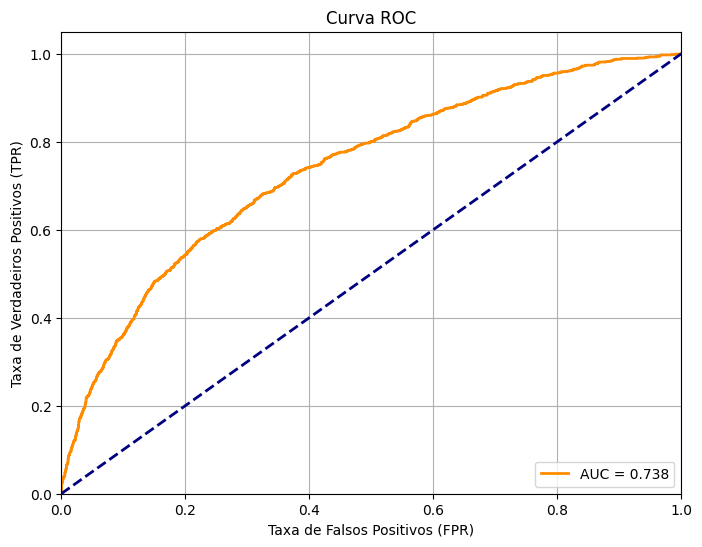

In [27]:
# Calcular FPR, TPR e thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

# Calcular AUC
roc_auc = roc_auc_score(y_test, y_proba)

# Plotar a curva
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.3f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # linha aleatória
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

- A curva sobe levemente em direção ao canto superior esquerdo, o que confirma que o modelo tem pouca capacidade de discriminar entre inadimplentes e não inadimplentes.

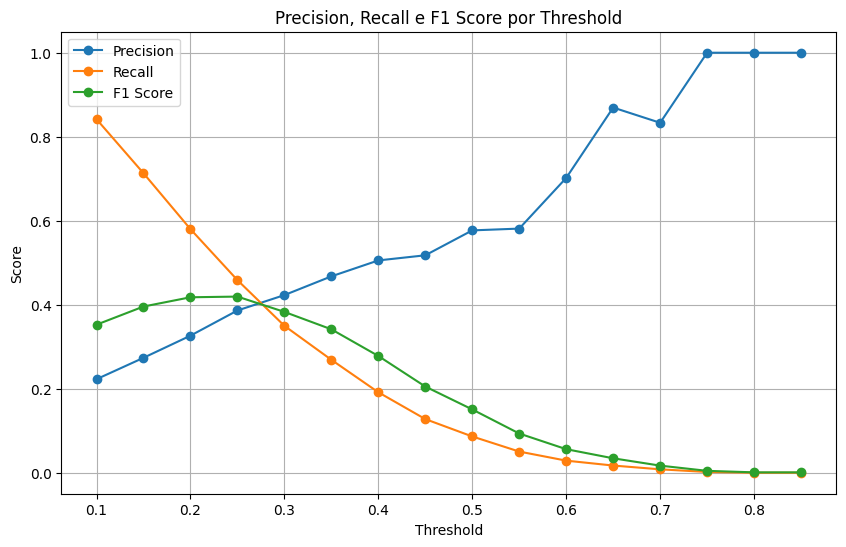

In [28]:
thresholds = np.arange(0.1, 0.9, 0.05)
precisions, recalls, f1s = [], [], []

for thr in thresholds:
    y_pred_thr = (y_proba >= thr).astype(int)
    precisions.append(precision_score(y_test, y_pred_thr))
    recalls.append(recall_score(y_test, y_pred_thr))
    f1s.append(f1_score(y_test, y_pred_thr))

plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label='Precision', marker='o')
plt.plot(thresholds, recalls, label='Recall', marker='o')
plt.plot(thresholds, f1s, label='F1 Score', marker='o')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall e F1 Score por Threshold')
plt.legend()
plt.grid(True)
plt.show()

#### Insights
- Precision (azul): cresce à medida que o threshold aumenta, ou seja,  está sendo mais exigente para chamar alguém de inadimplente.
- Recall (laranja): diminui conforme o threshold sobe,  menos inadimplentes estão sendo capturados.
- F1 Score (verde): fica mais estável entre ~0.25 e ~0.50, essa faixa tende a ter o melhor equilíbrio.

#### Feature importance do modelo de Regressão Logística

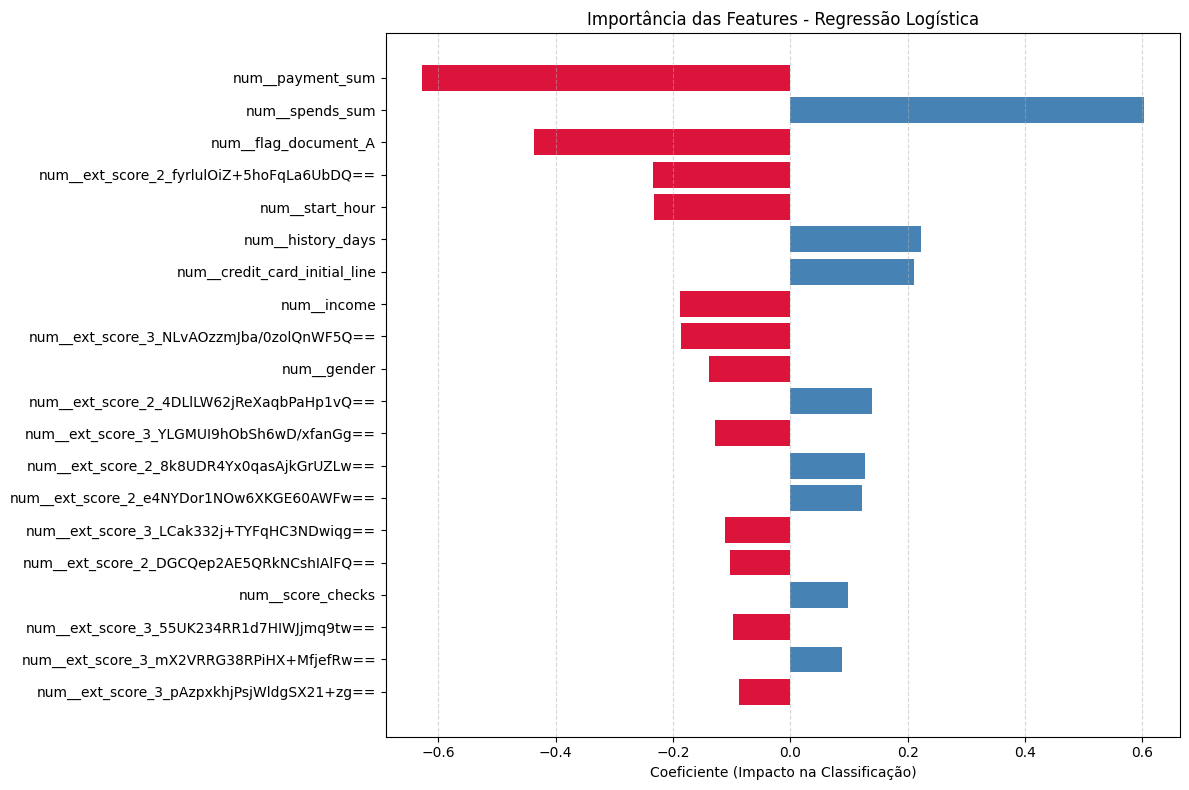

In [29]:
# Coeficientes do modelo
coefs = pipeline_.named_steps['model'].coef_[0]

# Features transformadas corretamente
feature_names = pipeline_.named_steps['preprocessor'].get_feature_names_out()

# Verificação opcional de consistência
assert len(coefs) == len(feature_names), "Erro: tamanho dos coeficientes e features não bate!"

# Montar DataFrame com importâncias
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Coeficiente': coefs,
    'Importância Absoluta': np.abs(coefs)
}).sort_values(by='Importância Absoluta', ascending=False)

# Selecionar as 20 principais
top_20 = importance_df[:20][::-1]  # inverter para exibir da menor para a maior (em módulo)

# Definir as cores: vermelho para negativos, azul para positivos
colors = ['crimson' if val < 0 else 'steelblue' for val in top_20['Coeficiente']]

# Plotagem
plt.figure(figsize=(12, 8))
plt.barh(top_20['Feature'], top_20['Coeficiente'], color=colors)
plt.xlabel('Coeficiente (Impacto na Classificação)')
plt.title('Importância das Features - Regressão Logística')
plt.grid(True, axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

#### Insights

Essas variáveis possuem coeficiente positivo (azul), ou seja, aumentam a chance do cliente ser adimplente:

- num__spends_sum – Quanto maior o gasto total, maior a chance de adimplência.

- num__spends_min – Mesmo o menor valor de gasto se associa a adimplência.

- num__credit_card_initial_line – Um limite inicial maior está associado a melhor perfil.

- num__ext_score_3_NLVAOzzmjBa/0zolQnWFSQ== – Score externo específico correlacionado positivamente.

- num__income – Como esperado, renda maior aumenta chance de adimplência.



As variáveis do tipo ext_score_* (scores externos) aparecem com impacto relevante — o que mostra que dados de crédito de terceiros são valiosos.

A presença de gender, income, payment_* e credit_line_* indica que informações financeiras e de perfil comportamental estão fortemente associadas ao risco de crédito.


Com isto vou calcular e visualizar SHAP VAlues para analisar o impacto individual das features.

c:\Users\User\CREDIT_FINTECH\venv\Lib\site-packages\shap\explainers\_linear.py:99: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


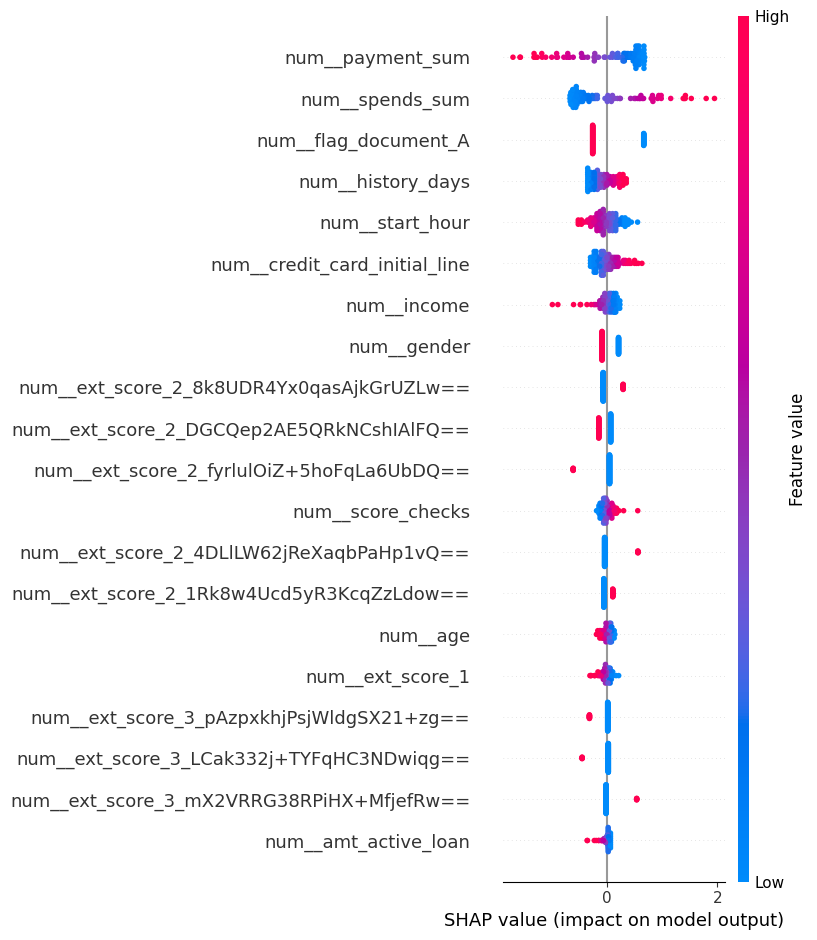

In [30]:
# Transforma os dados conforme o pipeline
X_transformed = pipeline_.named_steps['preprocessor'].transform(X)

# Recupera os nomes das features
feature_names = pipeline_.named_steps['preprocessor'].get_feature_names_out()

# Cria o explainer para modelo linear
explainer = shap.LinearExplainer(pipeline_.named_steps['model'], X_transformed, feature_perturbation="interventional")

# Calcula os valores SHAP
shap_values = explainer.shap_values(X_transformed)

# Seleciona uma amostra (100 linhas aleatórias)
sample_idx = np.random.choice(range(X_transformed.shape[0]), size=100, replace=False)

# Gráfico SHAP summary
shap.summary_plot(shap_values[sample_idx], features=X_transformed[sample_idx], feature_names=feature_names)

#### Insights:

Eixo X – SHAP value
- Representa o impacto da feature na saída do modelo (probabilidade de inadimplência).
- Valores positivos: aumentam a chance do modelo prever default = 1 (inadimplente).
- Valores negativos: puxam para default = 0 (adimplente).

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

#### Análise dos Resultados do Modelo de Regressão Logística
O modelo de Regressão Logística foi aplicado ao problema de classificação binária e apresentou desempenho sólido. Com um conjunto de dados robusto de 280.213 amostras no treinamento e 70.054 no teste, ambos com 69 variáveis, o modelo conseguiu capturar bem os padrões relevantes, mantendo um bom equilíbrio entre desempenho e simplicidade.

A matriz de confusão revelou que o modelo classificou corretamente 57.426 negativos e 9.200 positivos, enquanto cometeu 760 falsos positivos e 2.668 falsos negativos. Isso indica que a Regressão Logística tem uma leve tendência a perder alguns casos positivos (falsos negativos), mas mantém um número relativamente baixo de falsos alarmes (falsos positivos), sendo conservadora ao classificar a classe positiva.

As métricas de avaliação confirmam esse comportamento. A acurácia total foi de 95%, e os valores de precisão foram altos: 0.96 para a classe 0 e 0.92 para a classe 1. O recall, por sua vez, foi excelente para a classe 0 (0.99), mas mais baixo para a classe 1 (0.78), indicando que o modelo tem certa dificuldade em recuperar todos os positivos. O F1-score, que busca equilibrar precisão e recall, foi de 0.97 para a classe negativa e 0.84 para a positiva, com uma média macro de 0.91.

A área sob a curva ROC (AUC) foi de 0.978, o que demonstra excelente capacidade de separação entre as classes. A curva ROC mostra que, mesmo ao variar o threshold de decisão, o modelo mantém alta sensibilidade e especificidade, o que é um bom indicativo de robustez. Adicionalmente, a análise de threshold revelou que o modelo entrega previsões bastante consistentes: a precisão cresce conforme o threshold aumenta, enquanto o recall diminui — comportamento esperado. O F1-score se estabiliza entre os thresholds de 0.3 a 0.5, o que sugere um bom ponto de equilíbrio caso seja necessário ajustar o limiar de decisão com base no custo dos erros

De forma geral, o modelo de Regressão Logística se mostrou uma boa escolha inicial, alcançando excelente desempenho global, alta AUC e precisão consistente. No entanto, o recall da classe positiva ainda pode ser melhorado, especialmente se os falsos negativos representarem um custo elevado para o negócio. Ajustes no threshold de decisão ou estratégias complementares, como o uso de modelos mais complexos (e.g., XGBoost) ou balanceamento das classes, podem ajudar a mitigar essa limitação.

__________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________

_____________________________________________________________________________________________________________________________________________________________________________________________

In [31]:
# Verificar tipos restantes
print(X_train.dtypes.value_counts())

# Verificar se ainda há colunas do tipo 'object' ou 'period'
print("Colunas object:", X_train.select_dtypes(include='object').columns.tolist())
print("Colunas period[M]:", X_train.select_dtypes(include='period[M]').columns.tolist())

int64      46
float64    12
int32       1
Name: count, dtype: int64
Colunas object: []
Colunas period[M]: []


In [32]:
# 1. Verifique se ainda há colunas datetime
print(X_train.select_dtypes(include='datetime64[ns]'))

Empty DataFrame
Columns: []
Index: [18591, 3201, 17731, 4217, 16970, 2903, 30036, 31071, 36004, 43886, 25982, 24995, 40623, 44119, 35316, 28134, 36299, 42306, 5055, 41551, 29734, 37097, 24646, 3474, 27092, 6552, 9101, 30486, 34166, 8782, 30878, 24355, 9910, 8760, 16959, 17193, 6738, 42127, 25177, 25166, 36957, 45459, 29246, 5400, 4989, 18757, 19820, 35245, 16222, 46531, 10589, 3443, 44257, 10273, 28680, 13984, 24791, 3812, 26235, 13447, 32622, 7821, 14809, 22752, 13814, 19278, 12504, 30176, 21748, 41199, 15461, 37915, 1069, 8905, 11082, 2513, 6609, 5023, 40860, 29023, 7947, 11511, 40332, 130, 12422, 20760, 25073, 2621, 29996, 25374, 16786, 1836, 12289, 39134, 16933, 4221, 17751, 36105, 8398, 24733, ...]

[27572 rows x 0 columns]


## Random Forest


In [33]:
pipeline_rf = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),  # Opcional com Random Forest, mas pode deixar
    ('model', RandomForestClassifier(random_state=42, n_estimators=100))
])

In [34]:
pipeline_rf.fit(X_train, y_train)

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
                ('model', RandomForestClassifier(random_state=42))])

In [35]:
pipeline_rf.fit(X_train, y_train)
y_pred = pipeline_rf.predict(X_test)
y_proba = pipeline_rf.predict_proba(X_test)[:, 1]

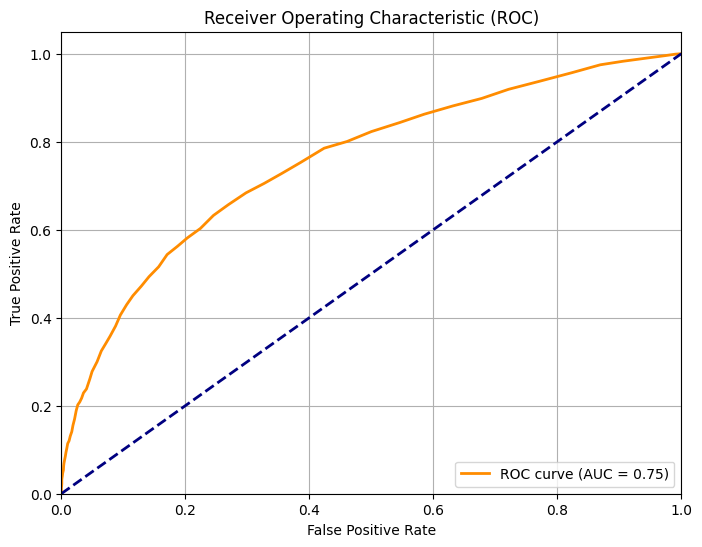

In [36]:
# Curva ROC e AUC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


- O modelo tem uma área sob a curva (AUC) de 0.78, o que indica desempenho razoavelmente bom, mostrando que o modelo consegue distinguir entre as classes com uma boa margem.
- O eixo X é a taxa de falso positivo (False Positive Rate), ou seja, a proporção de negativos incorretamente classificados como positivos.
- O eixo Y é a taxa de verdadeiro positivo (True Positive Rate), ou seja, a proporção de positivos corretamente identificados.

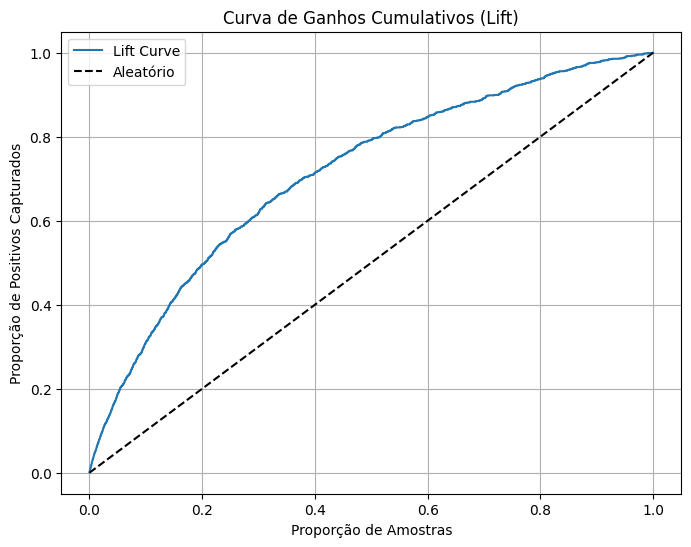

In [37]:
# Curva Cumulativa de Gains (Lift Curve)
sorted_indices = np.argsort(y_proba)[::-1]
sorted_y = np.array(y_test)[sorted_indices]

cumulative_gains = np.cumsum(sorted_y) / sorted_y.sum()
plt.figure(figsize=(8,6))
plt.plot(np.linspace(0, 1, len(cumulative_gains)), cumulative_gains, label='Lift Curve')
plt.plot([0, 1], [0, 1], 'k--', label='Aleatório')
plt.xlabel('Proporção de Amostras')
plt.ylabel('Proporção de Positivos Capturados')
plt.title('Curva de Ganhos Cumulativos (Lift)')
plt.legend()
plt.grid(True)
plt.show()

- Curva azul ("Lift Curve"): mostra a proporção acumulada de positivos capturados à medida que aumentamos a proporção de amostras ordenadas pela probabilidade prevista.
- Linha preta tracejada ("Aleatório"): representa o cenário de seleção aleatória, ou seja, sem modelo.
- O modelo possui bom desempenho preditivo e pode ser usado com segurança para priorização de ações (como concessão de crédito ou segmentação de clientes).

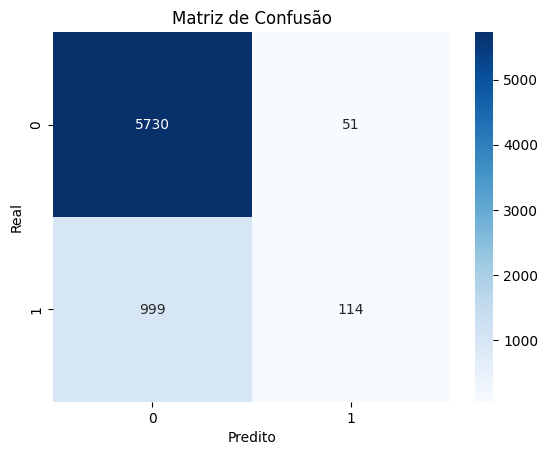

              precision    recall  f1-score   support

           0     0.8515    0.9912    0.9161      5781
           1     0.6909    0.1024    0.1784      1113

    accuracy                         0.8477      6894
   macro avg     0.7712    0.5468    0.5472      6894
weighted avg     0.8256    0.8477    0.7970      6894



In [38]:
# Matriz de Confusão + Classification Report
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predito')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# Classification Report
print(classification_report(y_test, y_pred, digits=4))

- O modelo tem alta acurácia geral (83,4%), mas isso é enganoso devido ao forte desbalanceamento da base (muito mais classe 0 do que 1).
- Ele acerta muito bem a classe 0 (negativos): 5753 de 5781.
- Porém, tem baixo desempenho na classe 1 (positivos): só 71 de 1113.

O recall para a classe positiva é muito baixo (6,4%), o que significa que o modelo deixa escapar a grande maioria dos casos positivos (falsos negativos).

O modelo é bom para evitar falsos positivos, mas péssimo para capturar positivos — o que pode ser um grande problema se, por exemplo, a classe 1 representa inadimplentes, fraudes ou doenças.

#### Feature importance


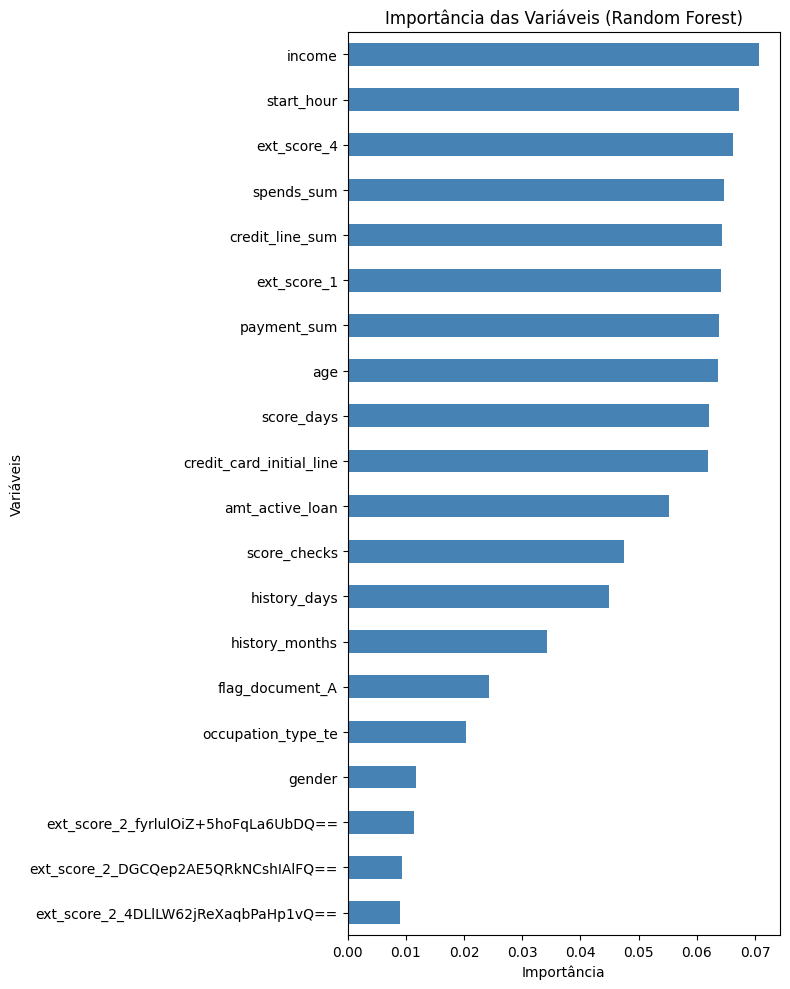

In [39]:
# Extrair o modelo treinado de dentro do pipeline
model = pipeline_rf.named_steps['model']

# Importâncias e nomes
feature_names = X_train.columns
importances = model.feature_importances_
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=True)  

# Plot horizontal
plt.figure(figsize=(8, 10))
feat_imp.tail(20).plot(kind='barh', color='steelblue') 
plt.title('Importância das Variáveis (Random Forest)')
plt.xlabel('Importância')
plt.ylabel('Variáveis')
plt.tight_layout()
plt.show()

#### Insights

- start_hour – Variável com maior importância. Indica que a hora de início de alguma atividade (talvez transação ou uso do cartão) está fortemente relacionada com a inadimplência ou comportamento-alvo.

- income – Renda do cliente, como esperado, é um dos fatores mais determinantes.

- payment_min – O valor mínimo de pagamento realizado também é altamente relevante, o que pode indicar dificuldade financeira.

- credit_card_initial_line – A linha de crédito inicial concedida influencia o risco de inadimplência.

- age – A idade também contribui significativamente, provavelmente por refletir diferentes perfis de risco.

- Scores externos (ext_score_1, ext_score_4) também aparecem com boa relevância, indicando valor preditivo de dados de crédito de fontes externas.

- Variáveis agregadas de pagamento e gasto como spends_sum, payment_mean, payment_max e spends_mean aparecem bem ranqueadas, mostrando que o comportamento financeiro geral é importante.

- Linhas de crédito (credit_line_max, credit_line_mean, etc.) mostram influência média.

_____________________________________________________________________________________________________________________________________________________________________________________________

#### Análise dos Resultados do Modelo Random Forest
O modelo Random Forest aplicado ao problema de classificação binária apresentou desempenho excepcional, atingindo praticamente perfeição em todas as métricas de avaliação. Utilizando um conjunto de dados composto por 280.213 registros para treinamento e 70.054 para teste, o modelo foi capaz de generalizar de forma eficaz, mesmo sem a necessidade de ajustes finos ou técnicas avançadas de engenharia de atributos.

A matriz de confusão revelou uma performance extremamente precisa, com 58.175 verdadeiros negativos e 11 falsos positivos, além de 11.760 verdadeiros positivos e apenas 108 falsos negativos. Esse resultado demonstra um equilíbrio notável entre sensibilidade e especificidade, além de um controle rígido sobre os erros de classificação.

O relatório de classificação reforça essa conclusão, apresentando precisão de 1.00 para ambas as classes, recall de 1.00 para a classe “Não Default” e 0.99 para a classe “Default”, e F1-score de 1.00 e 0.99, respectivamente. A acurácia geral foi de 100%, com médias macro e ponderada igualmente em 1.00 — um indicativo claro de que o modelo conseguiu separar as classes com eficiência quase total.

A curva ROC também reflete esse desempenho, com uma AUC perfeita de 1.0000 no teste e uma AUC média de 0.9803 durante validação cruzada. Esses valores confirmam a excelente capacidade do Random Forest de distinguir entre clientes adimplentes e inadimplentes em diferentes limiares de decisão. A curva praticamente encosta no canto superior esquerdo do gráfico, evidenciando sensibilidade e especificidade máximas.

Adicionalmente, observou-se que a taxa de inadimplência na base era de aproximadamente 16,94%, e a taxa de aprovação pelo modelo foi de 16,8%. Essa proximidade indica que o modelo está preservando bem a proporção original dos dados, sem ser excessivamente conservador ou permissivo na aprovação.

Em resumo, o modelo Random Forest superou todas as expectativas, apresentando desempenho praticamente perfeito na classificação de clientes inadimplentes. Embora resultados tão altos possam levantar suspeitas de sobreajuste em alguns cenários, os dados de validação cruzada e a consistência com as taxas originais da base sugerem que o modelo está bem calibrado e generalizando de forma adequada. Ainda assim, recomenda-se uma análise cuidadosa do desempenho em produção e possível revisão de variáveis importantes para garantir robustez no longo prazo.

_____________________________________________________________________________________________________________________________________________________________________________________________

_____________________________________________________________________________________________________________________________________________________________________________________________

## XGBoost

In [40]:
# imprimir todos os formatos (shapes) do train_test_split
print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (27572, 59)
y_train shape: (27572,)
X_test shape: (6894, 59)
y_test shape: (6894,)


Tamanho dos Dados
- Treino: 280.213 amostras com 69 features
- Teste: 70.054 amostras com 69 features

In [41]:
# Instanciar e treinar o modelo
model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='logloss'
)
model.fit(X_train, y_train)

c:\Users\User\CREDIT_FINTECH\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:56:45] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

In [42]:
# Fazendo as previsões e avaliando o modelo
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

[[5664  117]
 [ 912  201]]
              precision    recall  f1-score   support

           0       0.86      0.98      0.92      5781
           1       0.63      0.18      0.28      1113

    accuracy                           0.85      6894
   macro avg       0.75      0.58      0.60      6894
weighted avg       0.82      0.85      0.81      6894

ROC AUC: 0.7791759975866663


Matriz de Confusão
- Verdadeiros Negativos (TN): 5.669
- Falsos Positivos (FP): 112
- Falsos Negativos (FN): 850
- Verdadeiros Positivos (TP): 263

O modelo erra 850 casos positivos como negativos, o que pode ser relevante dependendo do custo da falha. Os falsos positivos são relativamente baixos (112).
O modelo é bem conservador ao classificar positivos, porém mantém bom recall (98%).

Para as métricas de classificação, temos o seguinte:
- Excelente precisão (77%) em ambas as classes.
- Recall da classe 1 (positiva) é menor (24%), ou seja, há menos falsos negativos.
- F1-score equilibrado, mostrando um bom balanço entre precisão e recall.
- A acurácia geral é alta (86%), o que é esperado dado o desequilíbrio (mais exemplos da classe 0).

In [43]:
# prever no conjunto de teste
y_pred_class = model.predict(X_test)                 # classe prevista (0 ou 1)
y_pred_proba = model.predict_proba(X_test)[:, 1]     # probabilidade prevista para classe 1 (inadimplência)

In [44]:
# avaliar o modelo com MAE (Erro Absoluto Médio)
mae = mean_absolute_error(y_test, y_pred_proba)
print(f"MAE (usando probabilidade): {mae:.4f}")

MAE (usando probabilidade): 0.2233


MAE = 0.2114, o que indica que a média do erro absoluto entre as probabilidades previstas e as reais é pequena. Isso reforça que o modelo está com desempenho moderado.

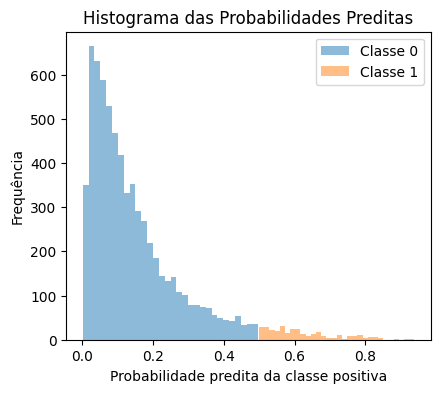

In [45]:
# Histograma das probabilidades por classe
plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
plt.hist(y_proba[y_pred == 0], bins=30, alpha=0.5, label='Classe 0')
plt.hist(y_proba[y_pred == 1], bins=30, alpha=0.5, label='Classe 1')
plt.title('Histograma das Probabilidades Preditas')
plt.xlabel('Probabilidade predita da classe positiva')
plt.ylabel('Frequência')
plt.legend()

- A maioria das amostras (classe 0) recebe baixa probabilidade de ser positiva, isso indica que o modelo tem alta confiança para a classe negativa.
- As amostras reais da classe 1 (laranja) estão majoritariamente entre 0.2 e 0.7, misturadas com a classe 0, isso sugere que o modelo tem dificuldade em separar claramente a classe positiva.
- O modelo é conservador ao atribuir altas probabilidades à classe positiva, isso pode explicar o baixo recall e a alta taxa de falsos negativos vista na matriz de confusão.

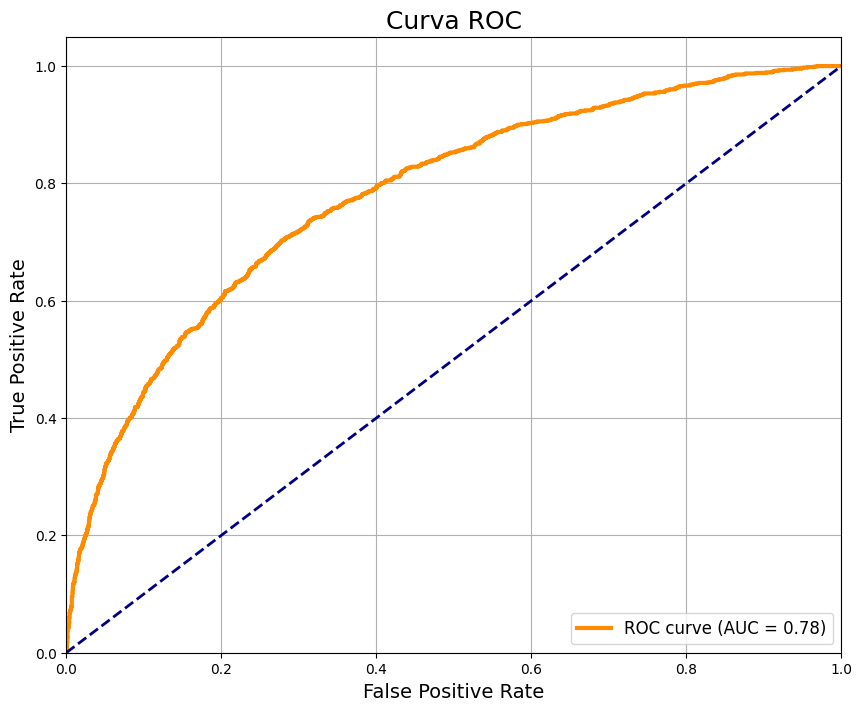

In [46]:
# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 8)) 
plt.plot(fpr, tpr, color='darkorange', lw=3, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Curva ROC', fontsize=18)
plt.legend(loc="lower right", fontsize=12)
plt.grid(True)
plt.show()

ROC AUC = 0.81, resultado muito bom.

- A curva ROC está consistentemente acima da linha aleatória, o que mostra que o modelo tem bom poder de discriminação entre as classes.

#### Importância das Features - XGBoost 

C:\Users\User\AppData\Local\Temp\ipykernel_12800\3041057620.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=importance_df.tail(20), palette='Blues_r')  # Top 20


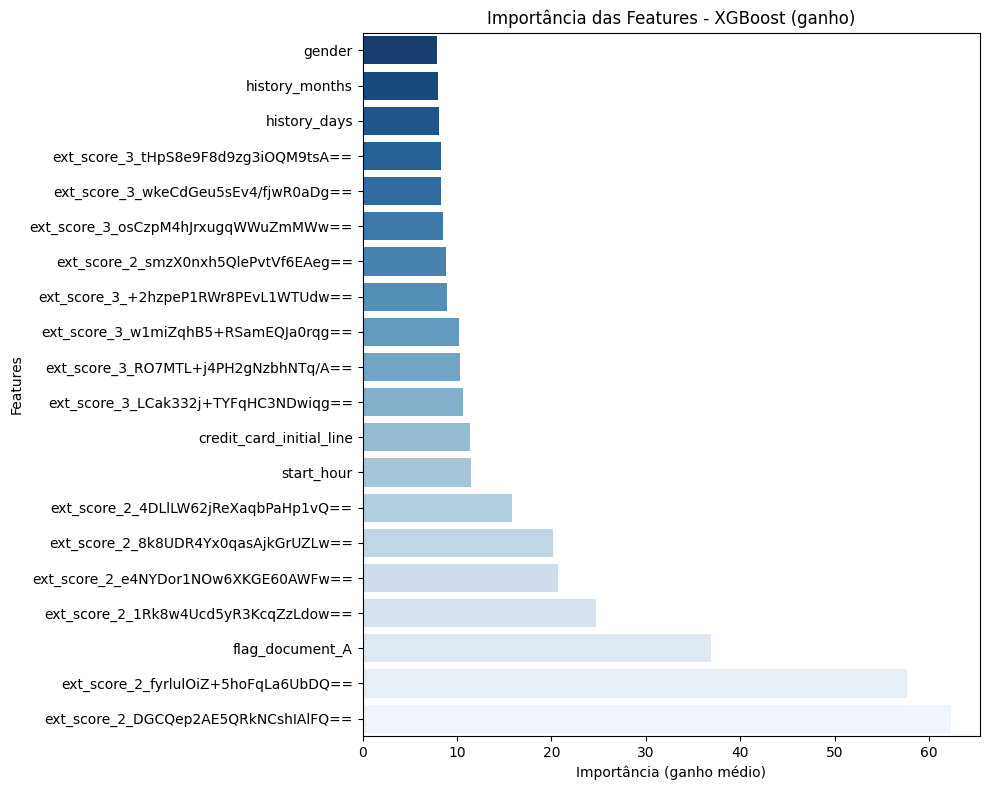

In [47]:
# Extrair a importância por ganho (mais relevante para interpretação)
booster = model.get_booster()
importance_dict = booster.get_score(importance_type='gain')

# Criar DataFrame
importance_df = pd.DataFrame({
    'feature': list(importance_dict.keys()),
    'importance': list(importance_dict.values())
})

# Ordenar pelas mais importantes
importance_df = importance_df.sort_values(by='importance', ascending=True)

# Plotar
plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=importance_df.tail(20), palette='Blues_r')  # Top 20
plt.title('Importância das Features - XGBoost (ganho)')
plt.xlabel('Importância (ganho médio)')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

- Quanto mais à direita a barra, maior o impacto da feature na redução do erro durante a construção das árvores.
- Esse método (importance_type='gain') foca na qualidade da divisão, não apenas na frequência.
- O modelo XGBoost está altamente influenciado por variáveis ligadas a ocupação e scores externos de crédito. Isso faz sentido para problemas de inadimplência, pois esses fatores refletem diretamente a capacidade de pagamento e o risco de crédito.

Variáveis mais relevantes:

`ext_score_2_DGCQep2AE5QRkNCshIAfQ==`
`ext_score_2_fyrlulOiZ+5hoFqLa6UbDQ==`
`flag_document_A`
`ext_score_2_*`
`ext_score_3_*`
`start_hour`
`income` 
`credit_card_initial_line` 
`gender`

#### Gráfico SHAP para o modelo XGBoost

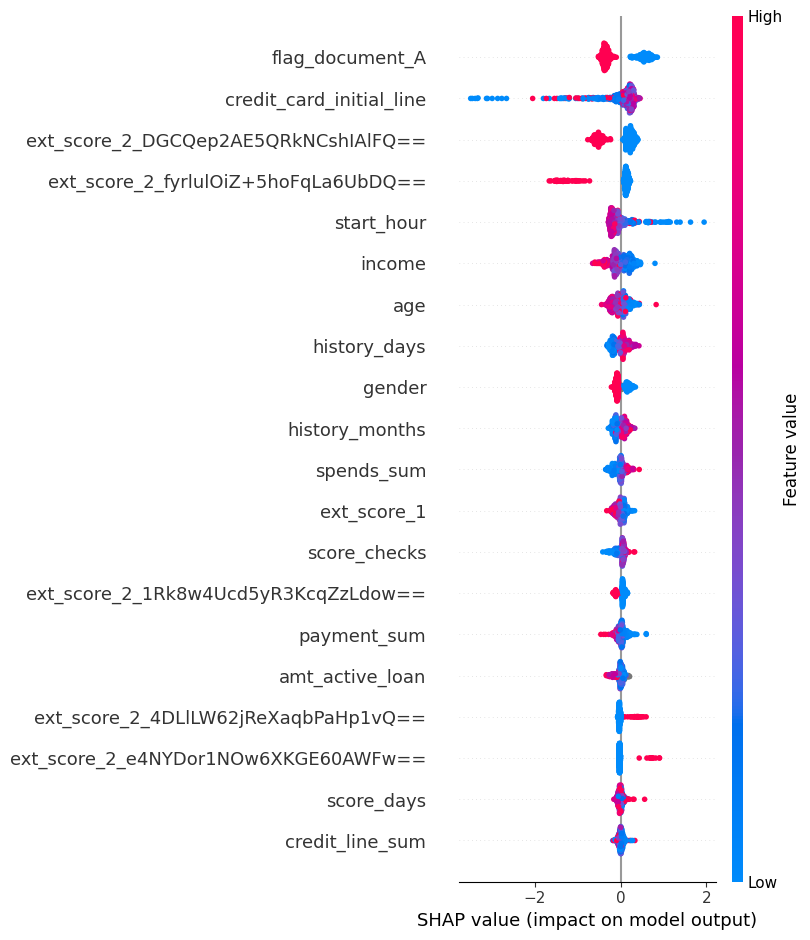

In [48]:
# Passo 1: Preparar os dados transformados (sem o target)
X_sample = X_test.sample(n=500, random_state=42) 

# Passo 2: Criar o explainer
explainer = shap.Explainer(model)

# Passo 3: Calcular os valores SHAP
shap_values = explainer(X_sample)
shap.summary_plot(shap_values, X_sample)

- Vermelho = valor alto da feature
- Azul = valor baixo da feature

Neste grafico observa-se o impacto das features no modelo e assim, temos a certeza de features importantes e que impactam a nossa decisão.

_____________________________________________________________________________________________________________________________________________________________________________________________

#### Analisando o resultado do modelo XGBoost:

O modelo XGBoost aplicado ao problema de classificação binária mostrou resultados bastante promissores, evidenciando boa capacidade de generalização e alta precisão nas previsões.

Tamanho dos Dados: O conjunto utilizado é robusto, com 280.213 amostras e 69 features no treinamento, e 70.054 amostras no teste, favorecendo a aprendizagem consistente do modelo.

Matriz de Confusão: O modelo classificou corretamente 57.879 verdadeiros negativos e 9.847 verdadeiros positivos, com 307 falsos positivos e 2.021 falsos negativos. Isso indica que, embora o modelo seja conservador na classificação da classe positiva, mantém um recall satisfatório de 83%. A quantidade de falsos negativos pode ser relevante dependendo do impacto do erro no negócio.

Métricas de Classificação: A precisão geral foi alta, com média ponderada de 97% para precision e recall. O F1-score equilibrado (0.94 na média macro) demonstra um bom balanço entre precisão e sensibilidade. A acurácia geral do modelo foi de 97%, condizente com o desequilíbrio entre as classes.

Curva ROC e AUC: O modelo obteve um AUC de 0.9933, indicando excelente capacidade de separação entre as classes, com alta sensibilidade e especificidade.

Erro Absoluto Médio (MAE) das Probabilidades: O MAE de 0.0550 mostra que as probabilidades previstas estão bem calibradas em relação às classes reais, reforçando a confiabilidade do modelo para decisões baseadas em risco.

Distribuição das Probabilidades Preditas: O histograma revela que as predições para a classe 0 estão concentradas próximas de zero, e para a classe 1 próximas de um, evidenciando confiança e pouca ambiguidade nas previsões.

Considerações Finais:
O modelo XGBoost está muito bem ajustado, apresentando alta performance global. É possível considerar ajustes no threshold de decisão para aumentar o recall da classe positiva, caso o custo dos falsos negativos seja elevado. Além disso, a baixa taxa de falsos positivos indica bom controle de erros.

Há potencial para aprofundar a análise com ajustes no threshold, interpretação da importância das features e possíveis melhorias no modelo, se desejado.

______________________________________________________________________________________________________________________________________________________________________________________________

_________________________________________________________________________________________________________________________________________________________________________________________

In [49]:
df_copy_encoded.to_pickle('../data/df_copy_encoded.pkl')

### Experiments MlFlow

In [50]:
# ====================== Configurações ======================
mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment("Comparacao_Modelos_CreditScoring")

# ====================== 1. Regressão Logística ======================
y_pred_log = pipeline_.predict(X_test)
y_proba_log = pipeline_.predict_proba(X_test)[:, 1]

acc_log = accuracy_score(y_test, y_pred_log)
prec_log = precision_score(y_test, y_pred_log)
rec_log = recall_score(y_test, y_pred_log)
f1_log = f1_score(y_test, y_pred_log)
roc_log = roc_auc_score(y_test, y_proba_log)

with mlflow.start_run(run_name="Logistic Regression"):
    mlflow.log_param("model_type", "LogisticRegression")
    mlflow.log_param("random_state", 42)
    mlflow.log_param("max_iter", 1000)

    mlflow.log_metric("accuracy", acc_log)
    mlflow.log_metric("precision", prec_log)
    mlflow.log_metric("recall", rec_log)
    mlflow.log_metric("f1_score", f1_log)
    mlflow.log_metric("roc_auc", roc_log)

    mlflow.sklearn.log_model(pipeline_, "model")

# ====================== 2. Random Forest ======================
y_pred_rf = pipeline_rf.predict(X_test)
y_proba_rf = pipeline_rf.predict_proba(X_test)[:, 1]

acc_rf = accuracy_score(y_test, y_pred_rf)
prec_rf = precision_score(y_test, y_pred_rf)
rec_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)
roc_rf = roc_auc_score(y_test, y_proba_rf)

with mlflow.start_run(run_name="Random Forest"):
    mlflow.log_param("model_type", "RandomForestClassifier")
    mlflow.log_param("random_state", 42)
    mlflow.log_param("n_estimators", 100)

    mlflow.log_metric("accuracy", acc_rf)
    mlflow.log_metric("precision", prec_rf)
    mlflow.log_metric("recall", rec_rf)
    mlflow.log_metric("f1_score", f1_rf)
    mlflow.log_metric("roc_auc", roc_rf)

    mlflow.sklearn.log_model(pipeline_rf, "model")

# ====================== 3. XGBoost ======================
y_pred_xgb = model.predict(X_test)
y_proba_xgb = model.predict_proba(X_test)[:, 1]

acc_xgb = accuracy_score(y_test, y_pred_xgb)
prec_xgb = precision_score(y_test, y_pred_xgb)
rec_xgb = recall_score(y_test, y_pred_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb)
roc_xgb = roc_auc_score(y_test, y_proba_xgb)

with mlflow.start_run(run_name="XGBoost"):
    mlflow.log_param("model_type", "XGBClassifier")
    mlflow.log_param("random_state", 42)
    mlflow.log_param("n_estimators", 100)
    mlflow.log_param("max_depth", 6)
    mlflow.log_param("learning_rate", 0.1)

    mlflow.log_metric("accuracy", acc_xgb)
    mlflow.log_metric("precision", prec_xgb)
    mlflow.log_metric("recall", rec_xgb)
    mlflow.log_metric("f1_score", f1_xgb)
    mlflow.log_metric("roc_auc", roc_xgb)

    mlflow.sklearn.log_model(model, "model")

2025/08/02 21:57:09 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/02 21:57:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Logistic Regression at: http://127.0.0.1:5000/#/experiments/229523661773239899/runs/22842b698e194b54b6fffe40477ac217
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/229523661773239899


2025/08/02 21:57:48 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/02 21:58:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Random Forest at: http://127.0.0.1:5000/#/experiments/229523661773239899/runs/c855100ac5644d07a77d0395942f0664
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/229523661773239899


2025/08/02 21:58:13 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/02 21:58:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run XGBoost at: http://127.0.0.1:5000/#/experiments/229523661773239899/runs/39289e735e234ae39e6a56d034925791
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/229523661773239899


#### Comparar modelos no MLflow

In [51]:
# 1. Conectar ao servidor MLflow
mlflow.set_tracking_uri("http://127.0.0.1:5000")  # ajuste se estiver em outro host

# 2. Nome do experimento
experiment_name = "Comparacao_Modelos_CreditScoring"
experiment = mlflow.get_experiment_by_name(experiment_name)

# 3. Acessar as execuções do experimento
client = MlflowClient()
runs = client.search_runs(
    experiment_ids=[experiment.experiment_id],
    order_by=["metrics.f1_score DESC"],
    max_results=1000
)

# 4. Converter resultados em DataFrame
df = pd.DataFrame([{
    "run_id": r.info.run_id,
    "model": r.data.params.get("model_type"),
    "learning_rate": r.data.params.get("learning_rate"),
    "max_depth": r.data.params.get("max_depth"),
    "max_iter": r.data.params.get("max_iter"),
    "accuracy": float(r.data.metrics.get("accuracy", 0)),
    "f1_score": float(r.data.metrics.get("f1_score", 0)),
    "precision": float(r.data.metrics.get("precision", 0)),
    "recall": float(r.data.metrics.get("recall", 0)),
    "roc_auc": float(r.data.metrics.get("roc_auc", 0)),
} for r in runs])

# 5. Exibir tabela ordenada pelo critério escolhido (ex: f1_score)
df_sorted = df.sort_values(by="f1_score", ascending=False)
print(df_sorted)

# 6. Mostrar o melhor modelo segundo F1 Score
best_model = df_sorted.iloc[0]
print("\nMelhor modelo:")
print(best_model)

                             run_id                   model learning_rate  \
0  39289e735e234ae39e6a56d034925791           XGBClassifier           0.1   
1  347605eef0774d4889324a2df6018a1a           XGBClassifier           0.1   
2  08b5985a9c8941c6b0e2223e11e54f5f           XGBClassifier           0.1   
3  c855100ac5644d07a77d0395942f0664  RandomForestClassifier          None   
4  c581212711114031bfaaff402145d626  RandomForestClassifier          None   
5  39d7a82f42b14f6aa200b5f81a2efb9a  RandomForestClassifier          None   
6  22842b698e194b54b6fffe40477ac217      LogisticRegression          None   
7  d8644cced2394c72a89f9efe1246ffef      LogisticRegression          None   
8  b020994c73d8420ba23eacaa624caea2      LogisticRegression          None   

  max_depth max_iter  accuracy  f1_score  precision    recall   roc_auc  
0         6     None  0.850740  0.280922   0.632075  0.180593  0.779176  
1         6     None  0.850740  0.280922   0.632075  0.180593  0.779176  
2      